In [37]:
#!pip install obspy
#!pip install pyts

ModuleNotFoundError: No module named 'pyts'

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# df_train = pd.read_csv("/kaggle/input/liverpool-ion-switching/train.csv")
# df_test = pd.read_csv("/kaggle/input/liverpool-ion-switching/test.csv")
df_train = pd.read_csv("train_clean.csv")
df_test = pd.read_csv("test_clean.csv")

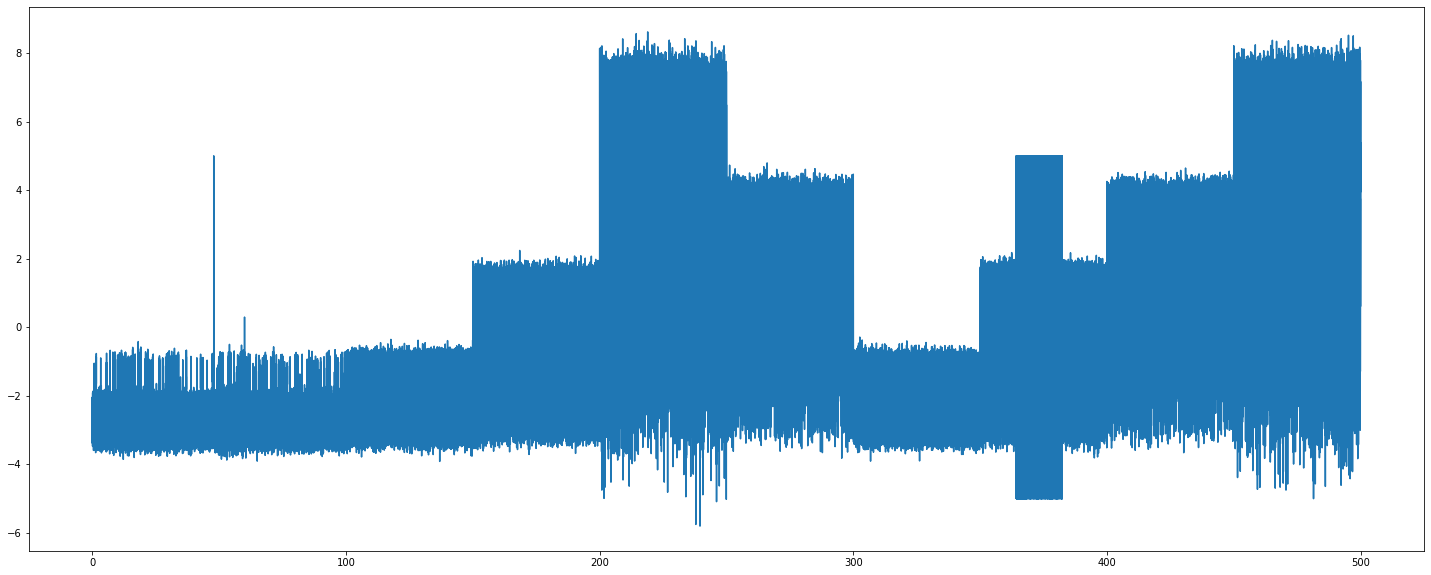

In [2]:

# GENERATE FEATURES
# TODO centered rolling feats, forward rolling feats

BATCH_SIZE = 500000
for i in range(10):
    df_train.loc[i * BATCH_SIZE:((i + 1) * BATCH_SIZE) - 1, 'batch'] = i

# TODO: fix batches for test (niso na 500k ampak na 100k za prva 2 batcha)
#for i in range(4):
#    df_test.loc[i * BATCH_SIZE:((i + 1) * BATCH_SIZE) - 1, 'batch'] = i

df_train['batch'] = df_train['batch'].astype(np.uint8)
#df_test['batch'] = df_test['batch'].astype(np.uint8)

# Rolling features
window_sizes = [10, 50, 500, 1000, 5000]
#window_sizes = [11, 25, 51, 101, 1001] # for centered

for window in window_sizes:
    df_train[f'rolling_mean_{window}'] = df_train.groupby('batch')['signal'].rolling(window=window, min_periods=1).mean()
    df_train[f'rolling_std_{window}'] = df_train.groupby('batch')['signal'].rolling(window=window, min_periods=1).std()
    df_train[f'rolling_var_{window}'] = df_train.groupby('batch')['signal'].rolling(window=window, min_periods=1).var()
    df_train[f'rolling_min_{window}'] = df_train.groupby('batch')['signal'].rolling(window=window, min_periods=1).min()
    df_train[f'rolling_max_{window}'] = df_train.groupby('batch')['signal'].rolling(window=window, min_periods=1).max()
    
    df_train[f'rolling_min_max_ratio_{window}'] = df_train[f'rolling_min_{window}'] / df_train[f'rolling_max_{window}']
    df_train[f'rolling_max_min_diff_{window}'] = df_train[f'rolling_max_{window}'] - df_train[f'rolling_min_{window}']
    
    norm = (df_train['signal'] - df_train[f'rolling_min_{window}']) / df_train[f'rolling_max_min_diff_{window}']
    df_train[f'norm_{window}'] = norm # * (np.floor(df_train[f'rolling_max_{window}']) - np.ceil(df_train[f'rolling_min_{window}']))

# Special features
df_train['signal_abs'] = abs(df_train['signal'])
df_train['signal_sq'] = df_train['signal'] ** 2
df_train['signal_sqroot'] = sign(df_train['signal']) * abs(df_train['signal']) ** 0.5

df_train = df_train.replace([np.inf, -np.inf], np.nan)
df_train.fillna(0, inplace=True)

#df_train['mean'] = df_train.groupby('batch')['signal'].rolling(WINDOW_SIZE, min_periods=1).mean().reset_index()['signal']

df_train.head()

plt.figure(figsize=(25, 10))
plt.plot(df_train.time, df_train.signal) #[500000*6-100:500000*6+100]
plt.plot(df_train.time, df_train.norm_10)
#plt.plot(df_train.time, df_train.open_channels+10)
#plt.plot(df_test.time, df_test.signal)

In [3]:
# GENERATE SEQUENCES

#SEQ_LEN_BEFORE = (5 - 1) // 2 + 1
#SEQ_LEN_AFTER = (5 - 1) // 2
SEQ_LEN_BEFORE = 50
SEQ_LEN_AFTER = 50
SEQ_LEN = SEQ_LEN_BEFORE + 1 + SEQ_LEN_AFTER

# TODO maybe: ne vsakič fillna (za train dropam, za test fillna)
def to_supervised(df, n_before=1, n_after=1):
    col = 'detrended'
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_before, 0, -1):
        cols.append(df.groupby('batch')[col].shift(i).fillna(method='bfill'))
        names.append(f'shift_t-{i}')
    
    # (t)
    cols.append(df[col])
    names.append(f'shift_t')
    
    # (t+1, ... t+n)
    for i in range(1, n_after+1):
        #cols.append(df.shift(-i).fillna(method='ffill'))
        cols.append(df.groupby('batch')[col].shift(-i).fillna(method='ffill'))
        names.append(f'shift_t+{i}')

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

df_train_X = to_supervised(df_train, SEQ_LEN_BEFORE, SEQ_LEN_AFTER)
#df_train_X.iloc[499_999:500010]

In [4]:
print(df_train_X.to_numpy().shape)

(5000000, 101)


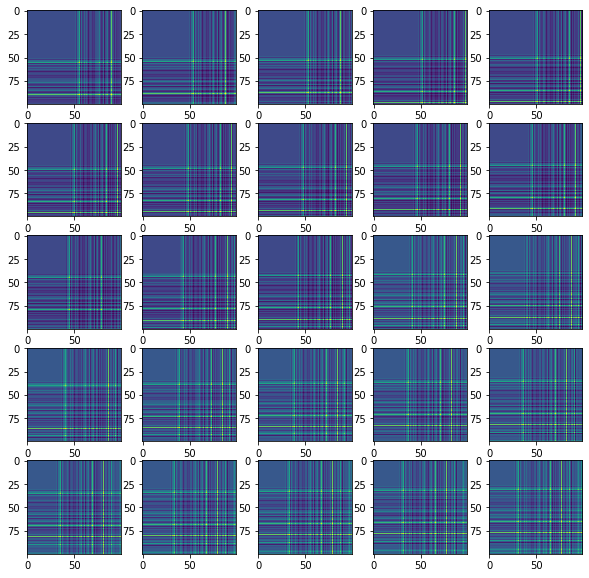

In [5]:
from pyts.image import GramianAngularField

gasf = GramianAngularField(image_size=100, sample_range=(0, 1), method='summation')
X_gasf = gasf.fit_transform(df_train_X.to_numpy()[4500000:5000000])

#print((df_train['open_channels'][7225:7250]))
fig = plt.figure(figsize=(10, 10))
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i*5+j+1)
        plt.imshow(X_gasf[i*5+j])

In [6]:
print(X_gasf.shape)

(500000, 100, 100)


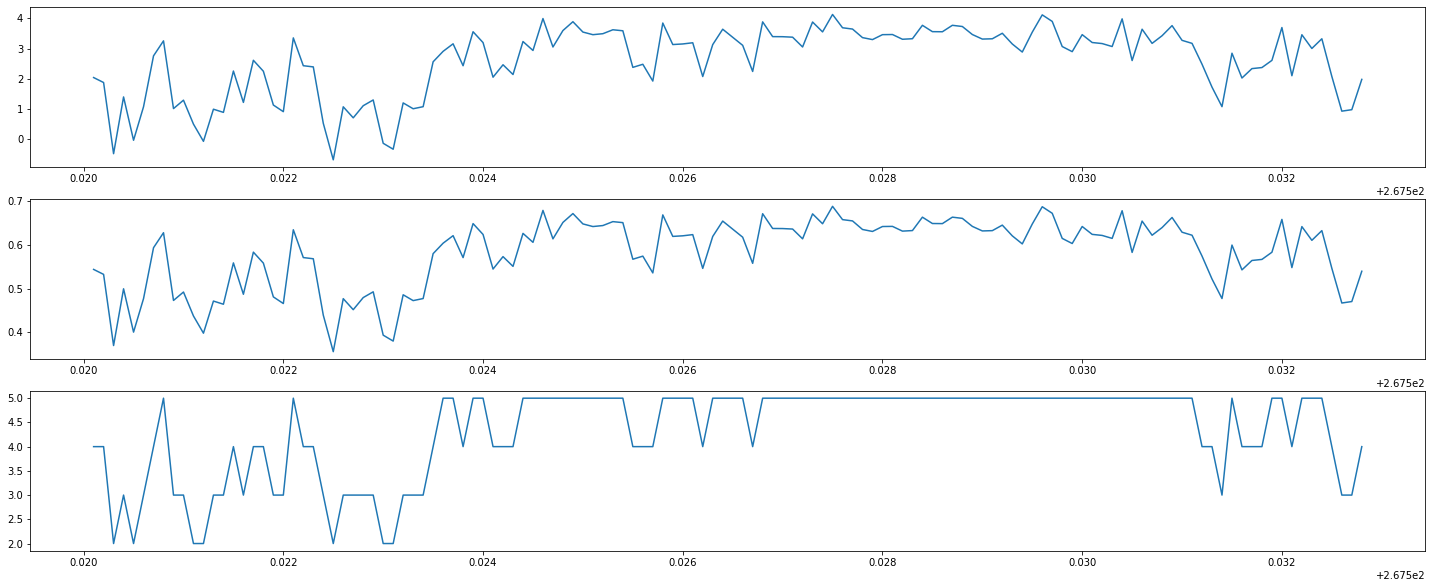

In [21]:
from sklearn.preprocessing import MinMaxScaler

seg = 20900

plt.figure(figsize=(25, 10))
plt.subplot(3, 1, 1)
#plt.plot(df_train.time[seg*500000:(seg+1)*500000], df_train.signal[seg*500000:(seg+1)*500000])
plt.plot(df_train.time[seg*128:(seg+1)*128], df_train.signal[seg*128:(seg+1)*128])

plt.subplot(3, 1, 2)
#plt.plot(df_train.time[seg*128:(seg+1)*128], df_train.detrended[seg*128:(seg+1)*128])
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(np.expand_dims(df_train.signal.to_numpy(), 1))
plt.plot(df_train.time[seg*128:(seg+1)*128], X_train[seg*128:(seg+1)*128])

plt.subplot(3, 1, 3)
#plt.plot(df_train.time[seg*500000:(seg+1)*500000], df_train.open_channels[seg*500000:(seg+1)*500000])
plt.plot(df_train.time[seg*128:(seg+1)*128], df_train.open_channels[seg*128:(seg+1)*128])

0     1240152
1      985865
3      668609
2      553924
4      403410
5      277877
7      265015
8      245183
6      188112
9      136120
10      35733
Name: open_channels, dtype: int64


<BarContainer object of 11 artists>

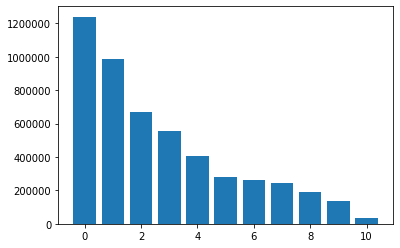

In [4]:
nuniq = df_train.open_channels.value_counts()
print(nuniq)
plt.bar(range(len(nuniq)), list(nuniq))

In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
from tensorflow.keras.models import Sequential, Model
from keras.regularizers import l2
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

# taken ResNet block but changed it to 1D
def get_model_res(input_shape, optimizer):
    
    def res_block(X, n_filters, conv_skip=False):
        X_skip = X
        if conv_skip:
            X_skip = Conv1D(filters=n_filters[2], kernel_size=1, strides=1, padding='same')(X_skip)
            X_skip = BatchNormalization()(X_skip)
            X_skip = Activation('relu')(X_skip)
        
        X = Conv1D(filters=n_filters[0], kernel_size=1, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv1D(filters=n_filters[1], kernel_size=3, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv1D(filters=n_filters[2], kernel_size=1, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Add()([X, X_skip])
        X = Activation('relu')(X)
        
        return X
        
    X_input = Input(shape=input_shape)
    X = Conv1D(filters=256, kernel_size=3, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=2)(X)
    
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [64, 64, 128], conv_skip=True)
    X = MaxPool1D(pool_size=2)(X)
    
    X = res_block(X, [64, 64, 128])
    X = res_block(X, [64, 64, 128])
    X = res_block(X, [64, 64, 128])
    X = res_block(X, [32, 32, 64], conv_skip=True)
    X = MaxPool1D(pool_size=2)(X)
    
    X = Bidirectional(GRU(128))(X)
    
    #X = Flatten()(X)
    #X = Dense(128, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(11, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X, name='ResLSTM')
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model


def get_model_images(input_shape, optimizer):

    X_input = Input(shape=input_shape)
    
    X = Conv2D(filters=128, kernel_size=3, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=2)(X)
    
    X = Conv2D(filters=256, kernel_size=3, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=2)(X)
    
    X = Conv2D(filters=128, kernel_size=3, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=2)(X)

    X = Flatten()(X)
    X = Dense(512)(X)
    X = Dense(11, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X, name='conv2d')
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model


def get_model_conv_lstm(input_shape, optimizer):
    
    def conv1d(layer_input, filters, dl=1, f_size=3, bn=True):
        d = Conv1D(filters, kernel_size=f_size, dilation_rate=dl, padding='same')(layer_input)
        #d = LeakyReLU(alpha=0.2)(d)
        d = Activation('relu')(d)
        if bn:
            d = BatchNormalization(momentum=0.99, epsilon=0.001)(d)
        return d
    
    x_input = Input(shape=input_shape)
    x_in_lstm = Permute((2, 1))(x_input)
    
    X = conv1d(x_input, 64)
    X = conv1d(X, 128, 2)
    X = conv1d(X, 256, 4)
    X = conv1d(X, 512, 8)
    X = conv1d(X, 512, 16)
    X = GlobalAveragePooling1D()(X)
    
    x = LSTM(128)(x_in_lstm)
    x = Dropout(0.5)(x)
    
    x = Concatenate()([x, X])
    x_output = Dense(11, activation='softmax')(x)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model


# https://github.com/ronakvijay/Protein_Sequence_Classification/blob/master/Pfam_protein_sequence_classification.ipynb
# taken from above link, ProtCNN model
def get_model_ProtCNN(input_shape, optimizer):
    
    def residual_block(data, filters, d_rate):
        shortcut = data

        bn1 = BatchNormalization()(data)
        act1 = Activation('relu')(bn1)
        conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

        #bottleneck convolution
        bn2 = BatchNormalization()(conv1)
        act2 = Activation('relu')(bn2)
        conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

        #skip connection
        x = Add()([conv2, shortcut])

        return x
        
    x_input = Input(shape=input_shape)

    #initial conv
    conv = Conv1D(128, 1, padding='same')(x_input) 

    # per-residue representation
    res1 = residual_block(conv, 128, 2)
    res2 = residual_block(res1, 128, 3)

    x = MaxPooling1D(3)(res2)
    x = Dropout(0.5)(x)
    
    #x = Bidirectional(GRU(128))(x) # my added

    # softmax classifier
    x = Flatten()(x)
    x_output = Dense(11, activation='softmax', kernel_regularizer=l2(0.0001))(x)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model


def get_model_custom(input_shape, optimizer):
    
    def res_block(X, n_filters, conv_skip=False):
        X_skip = X
        if conv_skip:
            X_skip = Conv1D(filters=n_filters[2], kernel_size=1, strides=1, padding='same')(X_skip)
            X_skip = BatchNormalization()(X_skip)
            X_skip = Activation('relu')(X_skip)
        
        X = Conv1D(filters=n_filters[0], kernel_size=1, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv1D(filters=n_filters[1], kernel_size=3, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv1D(filters=n_filters[2], kernel_size=1, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Add()([X, X_skip])
        X = Activation('relu')(X)
        
        return X
        
    X_input = Input(shape=input_shape)
    X = Conv1D(filters=256, kernel_size=3, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [64, 64, 128], conv_skip=True)
    
    X = Bidirectional(GRU(64, return_sequences=True))(X)
    
    X = Conv1D(filters=1, kernel_size=1, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Add()([X, X_input])
    
    X = Flatten()(X)
    #X = Dropout(0.2)(X)
    X = Dense(input_shape[0], activation='relu')(X)

    model = Model(inputs=X_input, outputs=X, name='sig2sig')
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    model.summary()
    return model


def get_model(input_shape, optimizer):

    def conv2d(layer_input, filters, f_size=3, bn=True):
        """Layers used during downsampling"""
        d = Conv1D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=3, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling1D(size=2)(layer_input)
        u = Conv1D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Add()([u, skip_input])
        return u
    
    n_filters = 64

    # Image input
    d0 = Input(shape=input_shape)

    # Downsampling
    d1 = conv2d(d0, n_filters, bn=False)
    d2 = conv2d(d1, n_filters*2)
    d3 = conv2d(d2, n_filters*4)
    d4 = conv2d(d3, n_filters*8)
    d5 = conv2d(d4, n_filters*8)
    d6 = conv2d(d5, n_filters*8)
    d7 = conv2d(d6, n_filters*8)

    # Upsampling
    u1 = deconv2d(d7, d6, n_filters*8)
    u2 = deconv2d(u1, d5, n_filters*8)
    u3 = deconv2d(u2, d4, n_filters*8)
    u4 = deconv2d(u3, d3, n_filters*4)
    u5 = deconv2d(u4, d2, n_filters*2)
    u6 = deconv2d(u5, d1, n_filters)

    u7 = UpSampling1D(size=2)(u6)
    
    #u7 = Bidirectional(GRU(64, return_sequences=True))(u7)
    
    output_img = Conv1D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(u7)
    output_img = Flatten()(output_img)

    model = Model(inputs=d0, outputs=output_img, name='sig2sig')
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    model.summary()
    return model
    

C:\Users\User\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\f

In [3]:
from tensorflow.keras.callbacks import Callback

class MacroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=-1)
        
    def on_epoch_end(self, epoch, logs={}):
        preds = np.argmax(self.model.predict(self.inputs), axis=-1)
        score = f1_score(self.targets, preds, average='macro')
        print(f' - val_macro_F1: {score:.5f}')

In [4]:
#TODO maybe: change the code so that sequences are created here instead of above
# creates a batch of bootstrapped examples
def batch_generator(batch_size, X, y, ordered_data=False):
    while True:
        idx = np.random.randint(0, X.shape[0], size=batch_size)
        x_batch = X[idx]
        y_batch = y[idx]
        
        yield (x_batch, y_batch)
        
# generates input and output sequences for signal-to-signal translation
def seq_generator(batch_size, X, y, seq_len):
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, seq_len, 1)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, seq_len)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(X.shape[0] - seq_len)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = X[idx:idx+seq_len]
            y_batch[i] = y[idx:idx+seq_len]
        
        #print(x_batch.shape)
        yield (x_batch, y_batch)

#X = np.array([[[1], [2]], [[3], [4]], [[5], [6]]])
#gen = batch_generator(2, X, X)

#X = np.array([[1], [2], [3], [4], [5], [6]])
#y = np.array([1, 2, 3, 4, 5, 6])
#gen = seq_generator(2, X, y, 3)

#print(next(gen))

Training 1. Fold
X_train shape:  (450000, 24, 24, 1)
y_train shape:  (450000, 11)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 24, 24, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 128)       1280      
_________________________________________________________________
batch_normalization_v1_15 (B (None, 24, 24, 128)       512       
_________________________________________________________________
activation_15 (Activation)   (None, 24, 24, 128)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 256)       295168    
____________________________________________________________

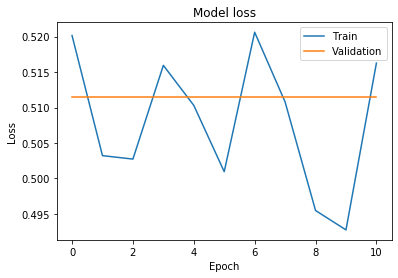

Training 2. Fold
X_train shape:  (450000, 24, 24, 1)
y_train shape:  (450000, 11)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 24, 24, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 128)       1280      
_________________________________________________________________
batch_normalization_v1_18 (B (None, 24, 24, 128)       512       
_________________________________________________________________
activation_18 (Activation)   (None, 24, 24, 128)       0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 12, 12, 256)       295168    
____________________________________________________________

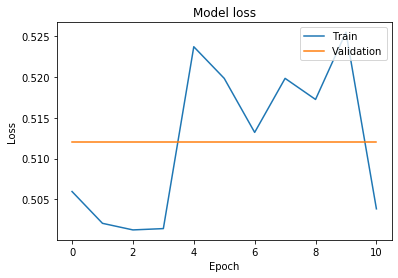

Training 3. Fold
X_train shape:  (450000, 24, 24, 1)
y_train shape:  (450000, 11)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 24, 24, 1)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 128)       1280      
_________________________________________________________________
batch_normalization_v1_21 (B (None, 24, 24, 128)       512       
_________________________________________________________________
activation_21 (Activation)   (None, 24, 24, 128)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 256)       295168    
____________________________________________________________

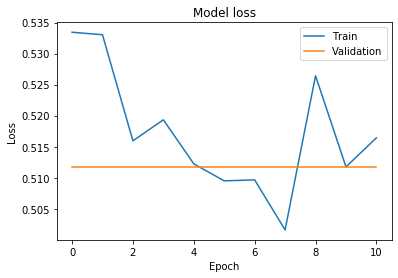

Training 4. Fold
X_train shape:  (450000, 24, 24, 1)
y_train shape:  (450000, 11)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 24, 24, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 128)       1280      
_________________________________________________________________
batch_normalization_v1_24 (B (None, 24, 24, 128)       512       
_________________________________________________________________
activation_24 (Activation)   (None, 24, 24, 128)       0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 12, 12, 256)       295168    
____________________________________________________________

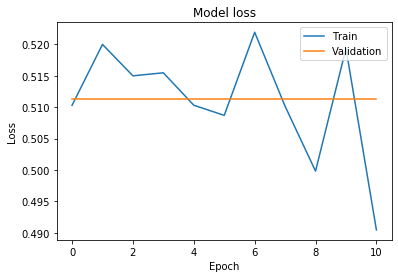

Training 5. Fold
X_train shape:  (450000, 24, 24, 1)
y_train shape:  (450000, 11)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 24, 24, 1)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 24, 128)       1280      
_________________________________________________________________
batch_normalization_v1_27 (B (None, 24, 24, 128)       512       
_________________________________________________________________
activation_27 (Activation)   (None, 24, 24, 128)       0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 12, 12, 256)       295168    
____________________________________________________________

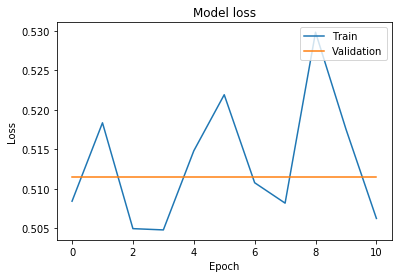

[0.4919370408381007, 0.4919370408381007, 0.4919370408381007, 0.4919370408381007, 0.4919370408381007]
0.4919370408381007


In [30]:
# FOR CLASSIFICATION (N-length signal -> 1 label)
#TODO shuffle training set somehow
#TODO split training set to training and validation

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, StratifiedShuffleSplit
from sklearn.metrics import f1_score

# macro f1 score with one-hot encoded labels
def macro_f1(yoh_true, yoh_pred):
    y_true = np.argmax(yoh_true, axis=-1)
    y_pred = np.argmax(yoh_pred, axis=-1)
    return f1_score(y_true, y_pred, average='macro')

# numpy data for training
seg = 0

#X = df_train_X.to_numpy()#[seg*500000:(seg+1)*500000]
X = X_gasf
y = df_train.open_channels.to_numpy()[seg*500000:(seg+1)*500000]
y_oh = to_categorical(y, num_classes=11)

groups = df_train.batch.to_numpy()[seg*500000:(seg+1)*500000]
#print(X.shape, y.shape)
#print(y)

# cross validation training
scores = []
#kf = GroupKFold(n_splits=10)
#kf = KFold(n_splits=2)
#kf = StratifiedKFold(n_splits=5)
kf = StratifiedShuffleSplit(n_splits=5, random_state=0)
for kth, (train_index, val_index) in enumerate(kf.split(X, y, groups)):
    print(f'Training {kth+1}. Fold')
    #print("TRAIN:", train_index, "VAL:", val_index)
    X_train, X_test = X[train_index], X[val_index]
    #y_train, y_test = y[train_index], y[val_index]
    yoh_train, yoh_test = y_oh[train_index], y_oh[val_index]
    
    # scale data to (-1, 1) range and reshape
    #x_scaler = MinMaxScaler(feature_range=(0, 1))
    #X_train = x_scaler.fit_transform(X_train)
    #X_test = x_scaler.transform(X_test)
    
    # for classification
    #X_train = X_train.reshape((-1, SEQ_LEN, 1))
    #X_test = X_test.reshape((-1, SEQ_LEN, 1))
    X_train = X_train[:,:,:, np.newaxis]
    X_test = X_test[:,:,:, np.newaxis]
    print('X_train shape: ', X_train.shape)
    print('y_train shape: ', yoh_train.shape)
    
    batch_size = 128
    gen = batch_generator(batch_size, X_train, yoh_train)
    
    # init model
    opt_adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #model = get_model((SEQ_LEN, 1), opt_adam)
    model = get_model((24, 24, 1), opt_adam)
    
    # define model callbacks
    callback_checkpoint = ModelCheckpoint(filepath=f'best_model_{kth}fold.h5', 
                               monitor='val_loss', 
                               verbose=1, 
                               save_weights_only=True, 
                               save_best_only=True)
    callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                           factor=0.5, 
                                           patience=0, 
                                           verbose=1, 
                                           min_delta=1e-4, 
                                           min_lr=1e-5)
    callback_tensorboard = TensorBoard(log_dir=f'./logs_{kth}fold/', histogram_freq=0, write_graph=False)
    callback_macro_f1 = MacroF1(model, X_test, yoh_test)
    #cbs = [callback_checkpoint, callback_early_stopping, callback_reduce_lr, callback_tensorboard]
    cbs = [callback_early_stopping, callback_reduce_lr]    
    
    # train model
    history = model.fit(x=gen, 
                        epochs=200, 
                        steps_per_epoch=100_000//batch_size, 
                        verbose=1, 
                        validation_data=(X_test, yoh_test),
                        callbacks=cbs)
    
    # calculate macro f1 on val set
    yoh_pred = model.predict(X_test)
    score = macro_f1(yoh_test, yoh_pred)
    print(f'val_macro_f1: {score}')
    scores.append(score)
    
    # plot loss and val_loss wrt epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
print(scores)
print(np.mean(scores))

In [28]:
yoh_pred = model.predict(X_test)
print(yoh_pred.shape)

#plt.figure(figsize=(25, 10))
#plt.plot(np.arange(SEQ_LEN), np.squeeze(X_test[220] * 10), color='blue', linewidth=10)
#plt.plot(np.arange(SEQ_LEN), y_test[220] * 10, color='orange', linewidth=5)
#plt.plot(np.arange(SEQ_LEN), np.rint(yoh_pred[220] * 10), color='black')

print(f1_score(np.argmax(yoh_test, axis=-1), np.argmax(yoh_pred, axis=-1), average='macro'))

(50000, 11)
0.4919370408381007


In [ ]:
# FOR SIGNAL-TO-SIGNAL TRANSLATION
#TODO split training set to training and validation

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, StratifiedShuffleSplit
from sklearn.metrics import f1_score

# macro f1 score
def macro_f1(y_true, y_pred):
    y_true = np.rint(y_true.reshape(-1))
    y_pred = np.rint(y_pred.reshape(-1))
    return f1_score(y_true, y_pred, average='macro')

# numpy data for training
seg = 9

X = df_train.signal.to_numpy()#[seg*500000:(seg+1)*500000]
X = X[:, np.newaxis]

y = df_train.open_channels.to_numpy()#[seg*500000:(seg+1)*500000]
y_oh = to_categorical(y, num_classes=11)

#print(X.shape, y.shape)
#print(y)

SEQ_LEN = 4096

# cross validation training
scores = []
#kf = GroupKFold(n_splits=10)
#kf = KFold(n_splits=2)
#kf = StratifiedKFold(n_splits=5)
kf = StratifiedShuffleSplit(n_splits=5, random_state=0)
for kth, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f'Training {kth+1}. Fold')
    #print("TRAIN:", train_index, "VAL:", val_index)
    X_train, X_test = X[train_index], X[val_index]
    y_train, y_test = y[train_index], y[val_index]
    #yoh_train, yoh_test = y_oh[train_index], y_oh[val_index]
    
    # scale data to (0, 1) range and reshape
    x_scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)
    
    y_train = y_train / 10
    y_test = y_test / 10
    
    # reshape validation data
    n_val_samples = y_test.shape[0] // SEQ_LEN * SEQ_LEN
    X_test = X_test[:n_val_samples].reshape((-1, SEQ_LEN, 1))
    y_test = y_test[:n_val_samples].reshape((-1, SEQ_LEN))
    
    # for classification
    #X_train = X_train.reshape((-1, SEQ_LEN, 1))
    #X_test = X_test.reshape((-1, SEQ_LEN, 1))
    print('X_train shape: ', X_train.shape)
    print('y_train shape: ', y_train.shape)
    
    batch_size = 128
    gen = seq_generator(batch_size, X_train, y_train, SEQ_LEN)
    
    # init model
    opt_adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model = get_model((SEQ_LEN, 1), opt_adam)
    
    # define model callbacks
    callback_checkpoint = ModelCheckpoint(filepath=f'best_model_{kth}fold.h5', 
                               monitor='val_loss', 
                               verbose=1, 
                               save_weights_only=True, 
                               save_best_only=True)
    callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                           factor=0.5, 
                                           patience=0, 
                                           verbose=1, 
                                           min_delta=1e-4, 
                                           min_lr=1e-5)
    callback_tensorboard = TensorBoard(log_dir=f'./logs_{kth}fold/', histogram_freq=0, write_graph=False)
    #callback_macro_f1 = MacroF1(model, X_test, yoh_test)
    #cbs = [callback_checkpoint, callback_early_stopping, callback_reduce_lr, callback_tensorboard]
    cbs = [callback_early_stopping, callback_reduce_lr]
    
    
    
    # train model
    history = model.fit(x=gen, 
                        epochs=200, 
                        steps_per_epoch=100_000//batch_size, 
                        verbose=1, 
                        validation_data=(X_test, y_test), 
                        callbacks=cbs)
    
    # calculate macro f1 on val set
    y_pred = model.predict(X_test)
    score = macro_f1(y_test * 10, y_pred * 10)
    print(f'val_macro_f1: {score}')
    scores.append(score)
    
    # plot loss and val_loss wrt epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
print(scores)
print(np.mean(scores))

Training 1. Fold
X_train shape:  (4500000, 1)
y_train shape:  (4500000,)
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 4096, 1)      0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 2048, 64)     256         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 2048, 64)     0           conv1d_8[0][0]                   
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 1024, 128)    24704       leaky_re_lu_7[0][0]   

Epoch 1/200
781/781 [==============================] - 250s 320ms/step - loss: 0.0092 - mean_absolute_error: 0.0647 - val_loss: 0.0058 - val_mean_absolute_error: 0.0525
Epoch 2/200
781/781 [==============================] - 253s 323ms/step - loss: 0.0055 - mean_absolute_error: 0.0504 - val_loss: 0.0054 - val_mean_absolute_error: 0.0490
Epoch 3/200
781/781 [==============================] - 262s 335ms/step - loss: 0.0053 - mean_absolute_error: 0.0478 - val_loss: 0.0053 - val_mean_absolute_error: 0.0472
Epoch 4/200
715/781 [==========================>...] - ETA: 20s - loss: 0.0052 - mean_absolute_error: 0.0464

In [ ]:
yoh_pred = model.predict(X_test)
print(yoh_pred.shape)

plt.figure(figsize=(25, 10))
plt.plot(np.arange(SEQ_LEN), np.squeeze(X_test[220] * 10), color='blue', linewidth=10)
plt.plot(np.arange(SEQ_LEN), y_test[220] * 10, color='orange', linewidth=5)
plt.plot(np.arange(SEQ_LEN), np.rint(yoh_pred[220] * 10), color='black')

print(f1_score(np.rint(y_test.reshape(-1) * 10), np.rint(yoh_pred.reshape(-1) * 10), average='macro'))

In [ ]:
def save_submission(y_test):
    submission = pd.read_csv("../input/liverpool-ion-switching/sample_submission.csv")
    submission["open_channels"] = np.asarray(y_test, dtype=np.int32)
    submission.to_csv("submission.csv", index=False, float_format="%.4f")